In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Introduction

This project involves developing a random forest model that predicts property prices based on a set 
of training data. First, we prepare the data by filling NA values by simple imputation 
methods. Then, we analyze the variables histogram and scatterplot to determine whether 
they need transformation. Lastly, we build the random forest model using the ranger package. 
 
The prediction error will be evaluated using RMLSE (Root Mean Squared Logarithmic Error)

# Data Pre-processing

First, checking for outliers, we see that there are properties with zero rooms, 
bathrooms, or kitchens. This could indicate errors when the data is recorded. Therefore, 
we will remove these observations.

In [4]:
# Loading Data
path = r"C:\Users\maian\OneDrive - University of Waterloo\Documents\UW\Projects\Data Sets\Random Forest\Training Data.csv"
dtrain = pd.read_csv(path)

In [7]:
dtrain.head(5)

,bathrm,hf_bathrm,heat,ac,rooms,bedrm,ayb,yr_rmdl,eyb,stories,...,roof,intwall,kitchens,fireplaces,landarea,latitude,longitude,nbhd,ward,quadrant
0,2,0,Forced Air,Y,6,3,1940.0,2011.0,1967,2.00,...,Slate,Hardwood,1.0,1,5473,40.748876,-74.124393,D9,Ward 5,NE
1,3,0,Hot Water Rad,Y,6,4,1933.0,2012.0,1972,2.25,...,Slate,Hardwood,1.0,2,7964,40.780493,-74.207416,B2,Ward 4,NW
2,2,0,Warm Cool,Y,7,2,1956.0,1978.0,1970,1.00,...,Comp Shingle,Hardwood,1.0,2,6750,40.664722,-74.095686,D2,Ward 7,SE
3,3,1,Warm Cool,Y,9,4,1977.0,2005.0,1993,2.00,...,Shake,Hardwood,2.0,2,7848,40.756657,-74.195369,C3,Ward 3,NW
4,2,1,Hot Water Rad,N,8,4,1923.0,NaN,1950,2.00,...,Slate,Hardwood,1.0,1,6250,40.785275,-74.173505,F1,Ward 4,NW


In [5]:
dtrain = dtrain[(dtrain['rooms'] != 0) & (dtrain['bathrm'] != 0) & (dtrain['bedrm'] != 0) & (dtrain['kitchens'].isna() == False)]
print(len(dtrain)) #seems like we removed 3 observations with no rooms

5996


How about NA values?

In [6]:
print(dtrain.isna().sum())

bathrm           0
hf_bathrm        0
heat             0
ac               0
rooms            0
bedrm            0
ayb             17
yr_rmdl       2406
eyb              0
stories          4
saledate         0
price            0
gba              0
style            0
grade            0
cndtn            0
extwall          0
roof             0
intwall          0
kitchens         0
fireplaces       0
landarea         0
latitude         0
longitude        0
nbhd             0
ward             0
quadrant        32
dtype: int64


It seems that we have quite a lot of NA values, we will consider one variable at a time. But first, do we really need the exact date of sales for each property? I will only keep the year and remove the dates. This way, we can treat this value as numerical

In [7]:
dtrain['saledate'] = pd.to_datetime(dtrain['saledate'])
dtrain['saledate'] = dtrain['saledate'].dt.year
dtrain['saledate'].head(5)

0    2013
1    2017
2    2015
3    2015
4    1993
Name: saledate, dtype: int32

That looks much better. Now, ayb is the year that the property was first built. To fill this value, we will use the average age of the other properties, then deduct the age from saledate.

In [8]:
avgAge = (dtrain['saledate'] - dtrain['ayb']).mean(skipna=True)
dtrain['ayb'].fillna(avgAge, inplace=True)
dtrain['ayb'].isna().sum() #Look at that! We have no missing value!

0

yr_rmdl is the year that the propety was remodelled. If the value is NA, then we can assume that the property has never been remodelled, and we can use ayb value instead.

In [9]:
dtrain['yr_rmdl'].fillna(dtrain['ayb'],inplace=True)
dtrain['yr_rmdl'].isna().sum()

0

The number of stories that were missing can potentially be extracted from style. Let's create a function for that

In [10]:
def extract_stories(style):
    style = style.lower()
    if "story" in style:
        word = style.split()
        return float(word[0])
    elif "bi" in style:
        return 2
    elif "split" in style:
        return 1.5
    else: 
        return 1

In [11]:
dtrain['stories'].fillna(dtrain['style'].apply(extract_stories), inplace = True)
dtrain['stories'].isna().sum()

0

Next, let's look at the coordinates of these properties to see how they are classified into quadrants. The black points are missing values

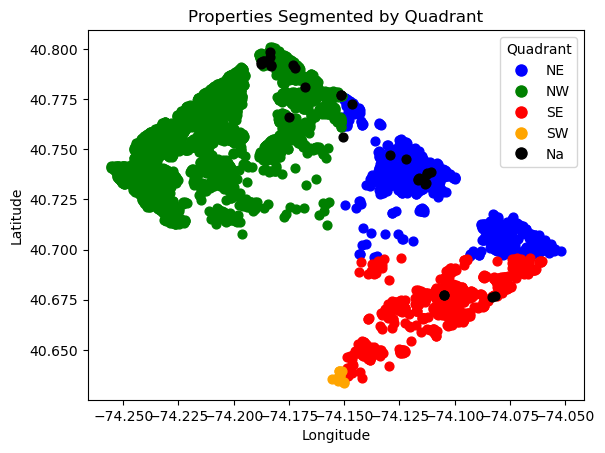

In [12]:
color_dict = {'NE': 'blue', 'NW': 'green', 'SE': 'red', 'SW': 'orange', 'Na': 'black'}

# Plotting
fig, ax = plt.subplots()
for quad, color in color_dict.items():
    if quad == 'Na':
        subset_data = dtrain[dtrain['quadrant'].isna()]
    else:
        subset_data = dtrain[dtrain['quadrant'] == quad]
    ax.scatter(subset_data['longitude'], subset_data['latitude'], label=quad, color=color, s=40)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Properties Segmented by Quadrant')

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=color_dict[quad]) for quad in color_dict]
labels = color_dict.keys()
plt.legend(handles, labels, title='Quadrant')

plt.show()

This seems like a perfect opportunity to apply k-nearest neighbor to fill these missing values, since we already have their coordinates.

In [13]:
from sklearn.neighbors import KNeighborsClassifier

def fill_quadrant_knn(data, k):
    complete_data = data[~data['quadrant'].isna()][["latitude", "longitude"]]
    complete_labels = data.loc[~data['quadrant'].isna(), 'quadrant']
    missing_data = data[data['quadrant'].isna()][["latitude", "longitude"]]

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(complete_data, complete_labels)
    knn_result = knn.predict(missing_data)

    data.loc[data['quadrant'].isna(), 'quadrant'] = knn_result
    return data

dtrain = fill_quadrant_knn(dtrain, 5)

labels = ["NE", "NW", "SE"]
for i, label in enumerate(labels, start=1):
    dtrain['quadrant'] = np.where(dtrain['quadrant'] == i, label, dtrain['quadrant'])
    
dtrain['quadrant'].isna().sum() #look at that! we just did a textbook case of KNN!

0

It seems that we finally finished data pre-processing! At last, let's double check and move onto building our model

In [14]:
print(dtrain.isna().sum().sum())

0


# Model Building

## Further Data Exploration

First, our most important variable - the response (aka property price). We definitely want it to be normal - distributed. But is it, though?

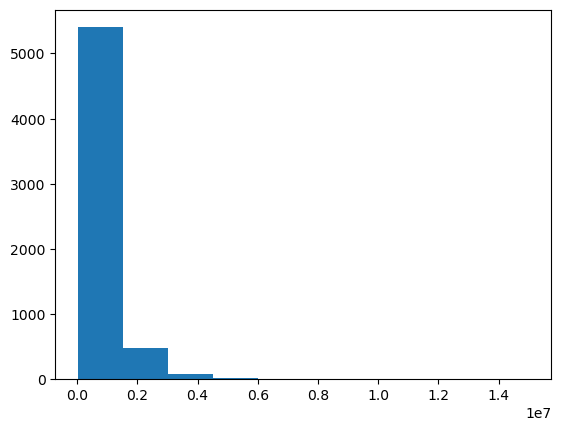

In [15]:
plt.hist(dtrain['price'])
plt.show()

This doesn't look normal-distributed at all. Since this is right-skewed, we will need to log-transform it.

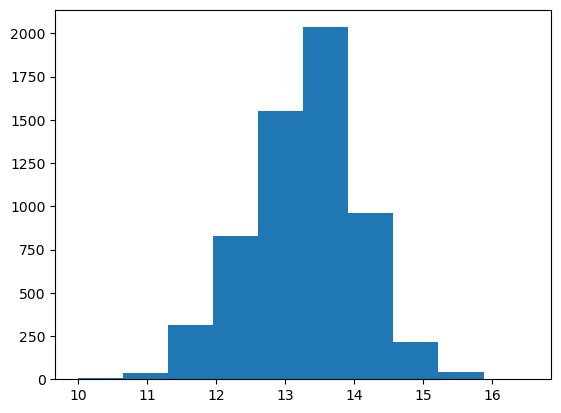

In [16]:
log_price = np.log(dtrain['price'])
plt.hist(log_price)
plt.show()

Looks perfect. Now, upon further investigating the data set, I realized something quite interesting. Some properties have saledate < ayb! This means the house was sold before it was even built. This means, considering this is a regression problem, having a saledate that is smaller than ayb can cause some trouble in our model. Thus, let's create another variable specifying this. We will call it "invest", which takes value of "Y" if the saledate of the house is smaller than ayb (aka it was an investment), and "N" otherwise.

In [17]:
dtrain['invest'] = np.where(dtrain['ayb'] > dtrain['saledate'], 'Y', 'N')

Lastly (trust me, we are almost there), considering that this is a large dataset with at least 27 explanatory variables, we really want to exclude some unnecessary variable to reduce the dimension. I mean, do we really need data of both bathrooms AND half-bathrooms? Probably not. So, let's combine it.  

## Random Forest

Here we have our default model. We will use this RMSE as a defaul score and try to improve prediction score by tuning huper-parameters. Well, I first did this project in R, where the ranger package handled categorical variables with grace. Upon my horror, this was not the case in Python, so we will have to perform one-hot encoding to convert these into proper factors.

In [43]:
path = r"C:\Users\maian\OneDrive - University of Waterloo\Documents\UW\Projects\Data Sets\Random Forest\Testing Data.csv"
dtest = pd.read_csv(path)

dtest['saledate'] = pd.to_datetime(dtest['saledate'])
dtest['saledate'] = dtest['saledate'].dt.year

avgAge = (dtest['saledate'] - dtest['ayb']).mean(skipna=True)
dtest['ayb'].fillna(avgAge, inplace=True)

dtest['yr_rmdl'].fillna(dtest['ayb'],inplace=True)

dtest['stories'].fillna(dtest['style'].apply(extract_stories), inplace = True)
dtest['kitchens'].fillna(0,inplace=True)

dtest = fill_quadrant_knn(dtest, 5)

labels = ["NE", "NW", "SE"]
for i, label in enumerate(labels, start=1):
    dtest['quadrant'] = np.where(dtest['quadrant'] == i, label, dtest['quadrant'])
    
dtest['invest'] = np.where(dtest['ayb'] > dtest['saledate'], 'Y', 'N')

In [45]:
dtest.isna().sum().sum()

0

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#Convert categorial variables with label encoder
from sklearn.preprocessing import LabelEncoder
# Create arrary of categorial variables to be encoded
categorical_cols = ['heat', 'style','ac', 'grade', 'cndtn', 'extwall', 'roof','intwall','nbhd','ward','quadrant','invest']
le = LabelEncoder()

# apply label encoder on categorical feature columns
dtrain[categorical_cols] = dtrain[categorical_cols].apply(lambda col: le.fit_transform(col))
dtest[categorical_cols] = dtest[categorical_cols].apply(lambda col: le.fit_transform(col))

y_train = np.log(dtrain["price"])
y_test = np.log(dtest["price"])

x_train = dtrain.drop(columns=["price"])
x_test = dtest.drop(columns=["price"])

# Initialize and fit the Random Forest model
model = RandomForestRegressor(n_estimators=500, random_state=123)
model.fit(x_train, y_train)

# Predict on the test set
y_pred = np.exp(model.predict(x_test))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)



Root Mean Squared Error: 0.0926295240859089


Amazing! Now, holding onto this value, we will perform hyper-parameter tuning and try to improve the model performance. Since manual grid is obviously computationally expensive, we will try random search to tune the model and find the best values for each parameters.

In [24]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = np.arange(20, 36, 5)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [500], 'max_features': ['auto', 'sqrt'], 'max_depth': array([20, 25, 30, 35]), 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [25]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\maian\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 30,
 'bootstrap': False}

In [51]:
tuned = RandomForestRegressor(n_estimators=500, random_state=123, min_samples_split=2,bootstrap=False)
tuned.fit(x_train, y_train)

y_pred = np.exp(tuned.predict(x_test))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.08672090506107465


It seems that we have improved upon the default model. Success!!!